In [53]:
import sklearn
import pandas as pd
import logging
import numpy as np
import sklearn.model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(420)
sklearn.random.seed(420)

## Part 0: Preprocess Dataset

This includes importing, sampling, one hot encoding / normalizing and lastly splitting into train and test data set

In [72]:
data_matrix = pd.read_csv("data.csv")
print("Import Successful")

# Transform Target Matrix
target_matrix = pd.read_csv("flowering_time.csv")
target_matrix = (target_matrix>40).astype(int)
print("Binary Target Variable created")

# 0. Sample 600 rows randomly
np.random.seed(420)

# First, generate indexes of selected rows
indexes = np.random.randint(low = 0, high = len(target_matrix)-1, size = 600).tolist()
print("Random Indexes generated")

sampled_predictors = data_matrix.iloc[indexes,:]
sampled_targets = target_matrix.iloc[indexes,:]
print("Random Rows Selected based on generated indexes")


# Identify categorical and continuous columns
categorical_columns = [categorical for categorical in list(sampled_predictors.columns) if categorical[0] == "g"]
continuous_columns = [categorical for categorical in list(sampled_predictors.columns) if categorical[0] != "g"]  # Replace with your actual continuous column names

# Define transformers for categorical and continuous columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('cont', StandardScaler(), continuous_columns)
    ])

sampled_predictors = preprocessor.fit_transform(sampled_predictors)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    sampled_predictors,
    sampled_targets,
    train_size = 2/3,
    random_state = 12345)


print("Train Test Split created")
print("Balance / Imbalance of our Train+Test Set:\n", sampled_targets.value_counts())

Import Successful
Binary Target Variable created
Random Indexes generated
Random Rows Selected based on generated indexes
Train Test Split created
Balance / Imbalance of our Train+Test Set:
 45.0
0       355
1       245
Name: count, dtype: int64


## Model Nr. 1: Basic Decision Tree Classifier

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

basicTreeClassifier = DecisionTreeClassifier(
    criterion = "entropy",
    splitter = "best",
    #max_depth = 10,
    min_samples_split = 2,
    random_state=42,
    max_depth=10
)

basicTreeClassifier.fit(X=X_train, y=Y_train)

predictions_tree = basicTreeClassifier.predict(X_test)

## Model Nr 2: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomForest = RandomForestClassifier(
    n_estimators=100, # To Play around with
    criterion="entropy"
)

randomForest.fit(X_train, Y_train.to_numpy().ravel())

predictions_randomforest = randomForest.predict(X_test)

## Model 3: XGBosst with adjusted Parameters

In [57]:
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# https://xgboosting.com/how-to-use-xgboost-xgbclassifier/
XGTree = xgboost.XGBClassifier(
    tree_method = "hist",
    random_state = 420,
    max_depth = 3,
    objective = "binary:logistic",
    eval_metric = "auc",
    n_estimators = 500,
    subsample = 0.9,
    learning_rate = 0.05
)

XGTree.fit(X_train, Y_train)
predictions_xgboost = XGTree.predict(X_test)

## Model 4: Standard Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression

logModel = LogisticRegression(
    penalty = "l2",
    dual=False,
    random_state=420,
    solver="lbfgs"
)
logModel.fit(X_train, Y_train)

predictions = logModel.predict(X_test)
# print(pd.Series(predictions).describe())
# Here we should do AUC ROC
predictions_logreg = (predictions > 0.1).astype(int)

c:\UPC\SEMESTER 2\STATISTICAL LEARNING\PART 1\PROJECT\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model Evaluation

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay

Key Points:
- Evaluate model performance using a confusion matrix.
- Calculate performance metrics including:
    -  Accuracy, Sensitivity, Specificity, and F1-score.
    -  Compare models using ROC curves

### Evaluation 1: Basic Decision Tree Classifier

Confusion Matrix:
[[93 26]
 [37 44]]
Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       119
           1       0.63      0.54      0.58        81

    accuracy                           0.69       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.68      0.69      0.68       200



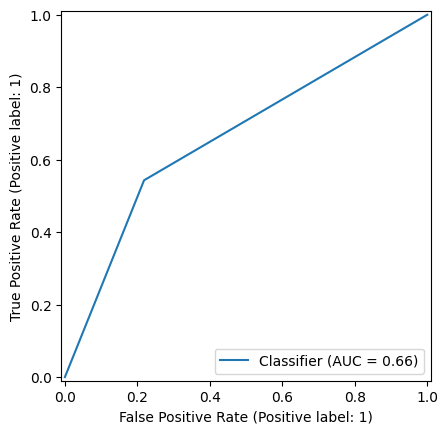

In [60]:
confusion_tree = confusion_matrix(Y_test, predictions_tree)
report_tree = classification_report(Y_test, predictions_tree)
accuracy_tree = accuracy_score(Y_test, predictions_tree)

print(f"Confusion Matrix:\n{confusion_tree}")
print(f"Accuracy: {accuracy_tree:.2f}")
print(f"Classification Report:\n{report_tree}")

RocCurveDisplay.from_predictions(Y_test, predictions_tree)

As we can see, we have an AUC of around 0.66, which is okay, but not great.
The accuracy of 0.69 is mainly due to 37 samples being predicted as 0 although they are indeed 1, which leads our specificity for class 1 to being only 0.54 ...

### Evaluation 2: Random Forest

Accuracy: 0.78
Confusion Matrix:
[[105  14]
 [ 31  50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       119
           1       0.78      0.62      0.69        81

    accuracy                           0.78       200
   macro avg       0.78      0.75      0.76       200
weighted avg       0.78      0.78      0.77       200



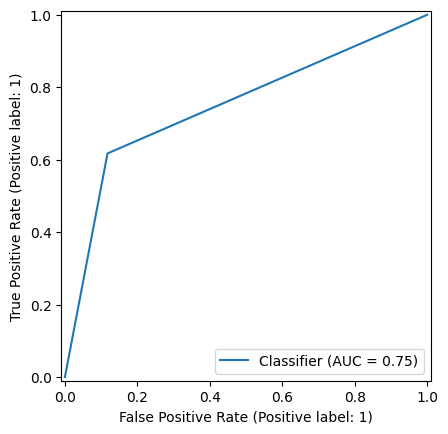

In [61]:
accuracy_randomforest = accuracy_score(Y_test, predictions_randomforest)
confusion_randomforest = confusion_matrix(Y_test, predictions_randomforest)
report_randomforest = classification_report(Y_test, predictions_randomforest)

print(f"Accuracy: {accuracy_randomforest:.2f}")
print(f"Confusion Matrix:\n{confusion_randomforest}")
print(f"Classification Report:\n{report_randomforest}")

RocCurveDisplay.from_predictions(Y_test, predictions_randomforest)

Description of results here

### Evaluation 3: XGBoost

Accuracy: 0.76
Confusion Matrix:
[[101  18]
 [ 31  50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80       119
           1       0.74      0.62      0.67        81

    accuracy                           0.76       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.75      0.76      0.75       200



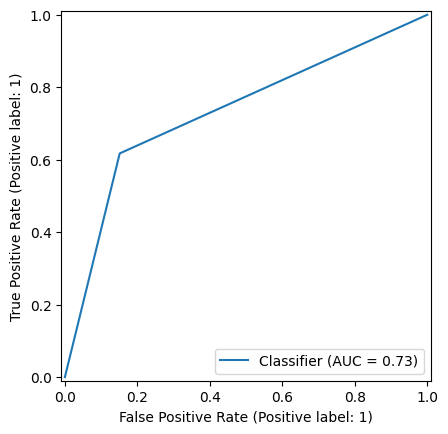

In [62]:
accuracy_xgboost = accuracy_score(Y_test, predictions_xgboost)
confusion_xgboost = confusion_matrix(Y_test, predictions_xgboost)
report_xgboost = classification_report(Y_test, predictions_xgboost)

print(f"Accuracy: {accuracy_xgboost:.2f}")
print(f"Confusion Matrix:\n{confusion_xgboost}")
print(f"Classification Report:\n{report_xgboost}")

RocCurveDisplay.from_predictions(Y_test, predictions_xgboost)

### Evaluation 4: Binary Logistic Regression

Accuracy: 0.58
Confusion Matrix:
[[95 24]
 [60 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       119
           1       0.47      0.26      0.33        81

    accuracy                           0.58       200
   macro avg       0.54      0.53      0.51       200
weighted avg       0.55      0.58      0.55       200



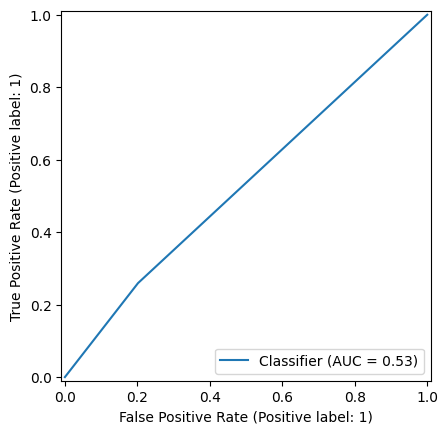

In [63]:
accuracy_logreg = accuracy_score(Y_test, predictions_logreg)
confusion_logreg = confusion_matrix(Y_test, predictions_logreg)
report_logreg = classification_report(Y_test, predictions_logreg)

print(f"Accuracy: {accuracy_logreg:.2f}")
print(f"Confusion Matrix:\n{confusion_logreg}")
print(f"Classification Report:\n{report_logreg}")

RocCurveDisplay.from_predictions(Y_test, predictions_logreg)

## Part 4: Hyperparameter Tuning

### Technique 1: Gridsearch

In [64]:
from sklearn.model_selection import GridSearchCV

### Optimization of Classical Decision Tree

Confusion Matrix:
[[92 27]
 [33 48]]
Accuracy:               precision    recall  f1-score   support

           0       0.74      0.77      0.75       119
           1       0.64      0.59      0.62        81

    accuracy                           0.70       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.70      0.70      0.70       200

Classification Report:
0.7


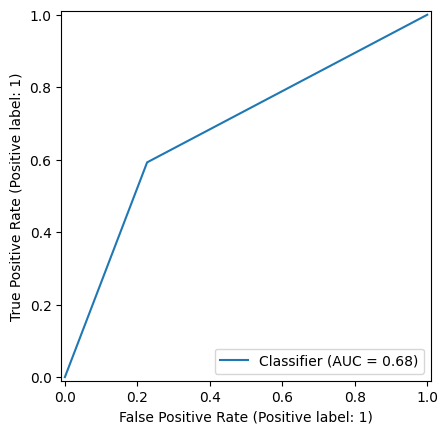

In [ ]:
tree = DecisionTreeClassifier()
param_grid = {
    "criterion": ["entropy", "gini", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [10,20,50,100,250,500],
    "min_samples_leaf":[1,2,5,10,20],

}
scoring = ["accuracy"]

gridSearchedTree = GridSearchCV(
    tree,
    param_grid=param_grid,
    scoring=scoring,
    cv=10, # 10-Fold Cross Validation,
    refit="acciracy"
)

gridSearchedTree.fit(X_train, Y_train)

best_tree = gridSearchedTree.best_estimator_
predictions_gridsearch_tree = best_tree.predict(X_test)

confusion_gridsearch_tree = confusion_matrix(Y_test, predictions_gridsearch_tree)
report_gridsearch_tree = classification_report(Y_test, predictions_gridsearch_tree)
accuracy_gridsearch_tree = accuracy_score(Y_test, predictions_gridsearch_tree)

print(f"Confusion Matrix:\n{confusion_gridsearch_tree}")
print(f"Accuracy: {report_gridsearch_tree}")
print(f"Classification Report:\n{accuracy_gridsearch_tree}")

RocCurveDisplay.from_predictions(Y_test, predictions_gridsearch_tree)

### Optimization of Random Forest

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


c:\UPC\SEMESTER 2\STATISTICAL LEARNING\PART 1\PROJECT\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
                    Value
criterion         entropy
max_depth            None
max_features          0.9
min_samples_leaf        1
n_estimators           50

Performance on Test Set:
              Value
Accuracy   0.795000
Precision  0.785714
Recall     0.679012
F1 Score   0.728477
Confusion Matrix:
[[104  15]
 [ 26  55]]
Accuracy: 0.795
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       119
           1       0.79      0.68      0.73        81

    accuracy                           0.80       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.80      0.79       200



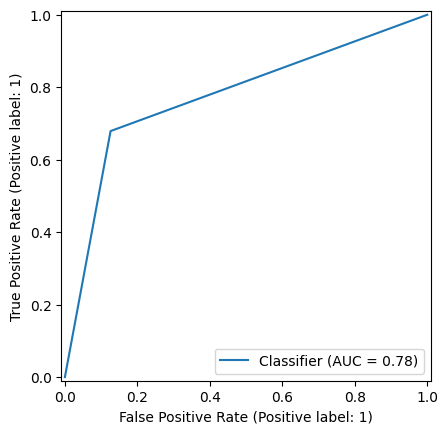

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

grid_forest = RandomForestClassifier()

param_grid = {
    "criterion": ["entropy", "gini", "log_loss"],
    "n_estimators": [50,100,200], # Probably the most important one
    "max_depth": [2,3,5,None],
    "min_samples_leaf":[1,2,5],
    "max_features": ["sqrt", "log2", 0.5, 0.7, 0.9, 1.0]
}
scoring = ["accuracy"]

gridSearchedForest = GridSearchCV(
    grid_forest,
    param_grid=param_grid,
    scoring=scoring,
    cv=10, # 10-Fold Cross Validation,
    refit="accuracy",
    n_jobs = -1,
    verbose=3
)


gridSearchedForest.fit(X_train, Y_train)

best_forest = gridSearchedForest.best_estimator_
best_params = gridSearchedForest.best_params_
predictions_gridsearch_forest = best_forest.predict(X_test)


# Best Parameters Table
print("\nBest Parameters:")
params_df = pd.DataFrame.from_dict(best_params, orient='index', columns=['Value'])
print(params_df.to_string())

confusion_gridsearch_forest = confusion_matrix(Y_test, predictions_gridsearch_forest)
report_gridsearch_forest = classification_report(Y_test, predictions_gridsearch_forest)
accuracy_gridsearch_forest = accuracy_score(Y_test, predictions_gridsearch_forest)
print("\nPerformance on Test Set:")
metrics_dict = {
    'Accuracy': accuracy_gridsearch_forest,
    'Precision': precision_score(Y_test, predictions_gridsearch_forest),
    'Recall': recall_score(Y_test, predictions_gridsearch_forest),
    'F1 Score': f1_score(Y_test, predictions_gridsearch_forest)
}
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
print(metrics_df.to_string())


print(f"Confusion Matrix:\n{confusion_gridsearch_forest}")
print(f"Accuracy: {accuracy_gridsearch_forest}")
print(f"Classification Report:\n{report_gridsearch_forest}")

RocCurveDisplay.from_predictions(Y_test, predictions_gridsearch_forest)

### Hyperparameter Tuning for XGBoost

Fitting 10 folds for each of 504 candidates, totalling 5040 fits

Best Parameters:
                            Value
colsample_bytree              0.7
eta                          0.05
max_depth                       6
n_estimators                 1000
nthread                         4
objective         binary:logistic
seed                          420
subsample                     1.0

Performance on Test Set:
              Value
Accuracy   0.750000
Precision  0.718310
Recall     0.629630
F1 Score   0.671053
Confusion Matrix:
[[99 20]
 [30 51]]
Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       119
           1       0.72      0.63      0.67        81

    accuracy                           0.75       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.75      0.75      0.75       200



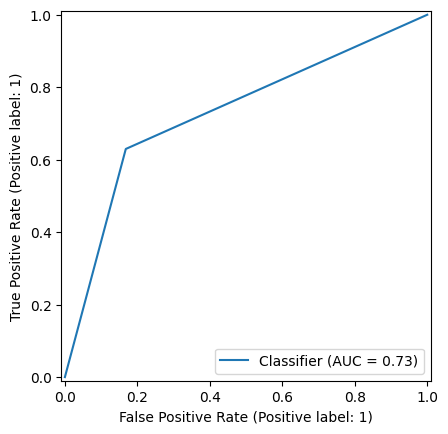

In [79]:
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# https://xgboosting.com/how-to-use-xgboost-xgbclassifier/
gridXG = xgboost.XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'eta': [0.05,0.1,0.2,0.3,0.4,0.5],
              'max_depth': [0, 2, 3, 4, 6, 7, 8],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.7],
              'n_estimators': [50,100,500,1000], #number of trees, change it to 1000 for better results
              'seed': [420]
}

scoring = "roc_auc"

gridSearchedXG = GridSearchCV(
    gridXG,
    param_grid=parameters,
    scoring=scoring,
    cv=10, # 10-Fold Cross Validation,
    refit = True,
    n_jobs = -1,
    verbose=3
)



gridSearchedXG.fit(X_train, Y_train)

best_XG = gridSearchedXG.best_estimator_
best_params = gridSearchedXG.best_params_
predictions_gridsearch_XG = best_XG.predict(X_test)

# Best Parameters Table
print("\nBest Parameters:")
params_df = pd.DataFrame.from_dict(best_params, orient='index', columns=['Value'])
print(params_df.to_string())

confusion_gridsearch_XG = confusion_matrix(Y_test, predictions_gridsearch_XG)
report_gridsearch_XG = classification_report(Y_test, predictions_gridsearch_XG)
accuracy_gridsearch_XG = accuracy_score(Y_test, predictions_gridsearch_XG)

print("\nPerformance on Test Set:")
metrics_dict = {
    'Accuracy': accuracy_gridsearch_XG,
    'Precision': precision_score(Y_test, predictions_gridsearch_XG),
    'Recall': recall_score(Y_test, predictions_gridsearch_XG),
    'F1 Score': f1_score(Y_test, predictions_gridsearch_XG)
}
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
print(metrics_df.to_string())

print(f"Confusion Matrix:\n{confusion_gridsearch_XG}")
print(f"Accuracy: {accuracy_gridsearch_XG}")
print(f"Classification Report:\n{report_gridsearch_XG}")

RocCurveDisplay.from_predictions(Y_test, predictions_gridsearch_XG)


### SVM Hyperparameter Tuning

In [86]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import numpy as np
from scipy.stats import uniform, loguniform

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=420))
])

parameters = {
    'svm__C': loguniform(1e-3, 1e3),
    'svm__gamma': loguniform(1e-4, 1e1),
    'svm__kernel': ['linear','rbf', 'poly', 'sigmoid'],
    'svm__class_weight': ['balanced', None], 
    'svm__degree': [2, 3]
}

# Step 3: Randomized search with cross-validation
# More efficient than grid search for large parameter spaces
svm_search = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=parameters,
    n_iter=150,  # Number of parameter settings sampled
    cv=10,  # 5-fold cross-validation
    scoring='accuracy',  # Optimize for F1 score
    n_jobs=-1,  # Use all available processors
    verbose=1,
    random_state=420
)

svm_search.fit(X_train, Y_train)

best_svm = svm_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Step 6: Print detailed results
print("\n" + "="*50)
print("BEST SVM MODEL RESULTS")
print("="*50)

print(f"\nBest parameters found:")
for param, value in svm_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest cross-validation Accuracy score: {svm_search.best_score_:.4f}")

print("\nTest set performance:")
print(f"Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, y_pred):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, y_pred))

print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


KeyboardInterrupt: 